In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pysal as ps
import seaborn as sns
import geopandas as gpd
import plotly.express as px

import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

import os
import pandas as pd

from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings("ignore")

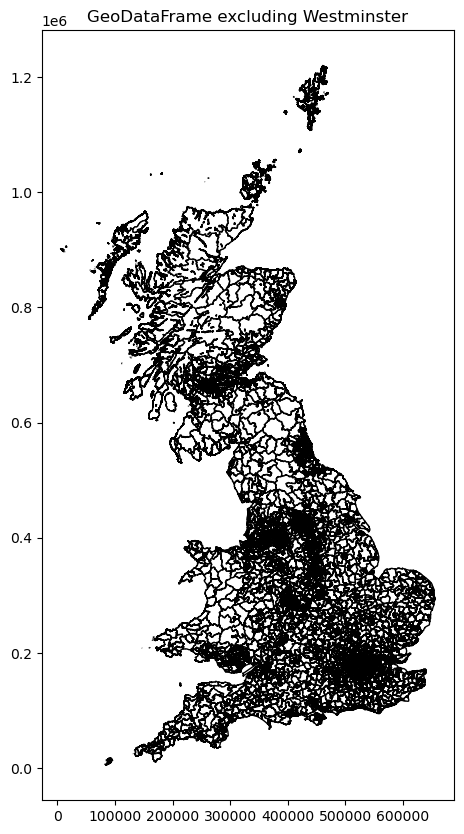

In [2]:
temp_msoa = gpd.read_file(f"data_collection/infuse_msoa_lyr_2011/infuse_msoa_lyr_2011.shp")
# Plot the filtered GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
temp_msoa.plot(ax=ax, color='white', edgecolor='black')

# Customize the plot
ax.set_title('GeoDataFrame excluding Westminster')
plt.show()

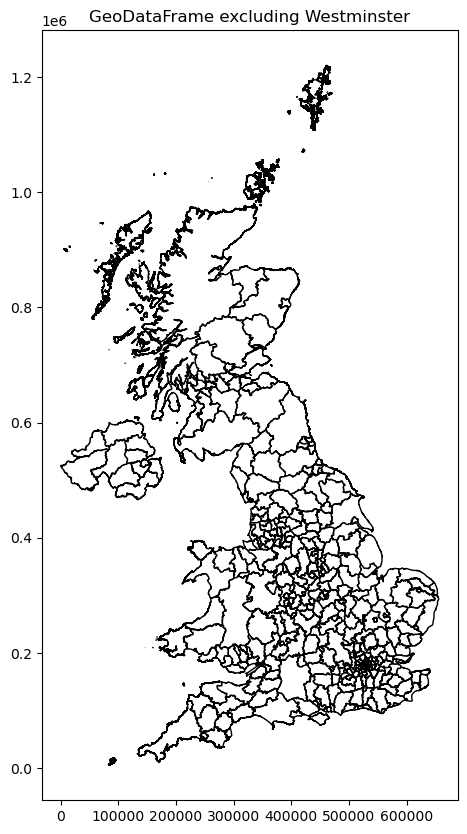

In [3]:
temp_lad = gpd.read_file(f"data_collection/LAD_May_2020_Boundaries_UK_BFE_2022_-5822860364470735119/Local_Authority_Districts__May_2020__Boundaries_UK_BFE.shp")
# Plot the filtered GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
temp_lad.plot(ax=ax, color='white', edgecolor='black')

# Customize the plot
ax.set_title('GeoDataFrame excluding Westminster')
plt.show()

In [4]:
collision = pd.read_csv('data_collection/2022/collision-2022.csv')

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Assuming collision is already loaded and contains 'location_easting_osgr' and 'location_northing_osgr'
# Assuming geo_df is your GeoDataFrame containing the 'geo_code' and 'geometry' columns


collision['lsoa_of_accident_location'] = -1
collision.rename(columns={'lsoa_of_accident_location': 'msoa_of_accident_location'}, inplace=True)


# Step 1: Convert the collision DataFrame to a GeoDataFrame
collision_gdf = gpd.GeoDataFrame(
    collision,
    geometry=gpd.points_from_xy(collision.location_easting_osgr, collision.location_northing_osgr),
    crs="EPSG:27700"  # Assuming the coordinate system is British National Grid
)

# Step 2: Perform a spatial join to match coordinates with polygons
joined_gdf = gpd.sjoin(collision_gdf, temp_msoa[['geo_code', 'geometry']], how="left", op="within")

# Merge the DataFrames on 'accident_index'
merged_df = collision.merge(joined_gdf[['accident_index', 'geo_code', 'geometry']], on='accident_index', how='left')

# Replace 'msoa_of_accident_location' with 'geo_code' where applicable
collision['msoa_of_accident_location'] = merged_df['geo_code']

# Step 4: Add the geometry to the collision DataFrame and convert it to a GeoDataFrame
collision = gpd.GeoDataFrame(
    collision,
    geometry=merged_df['geometry'],  # Use the geometry from the spatial join
    crs="EPSG:27700"  # Ensure the CRS is set correctly
)


In [6]:
# Count the number of occurrences of '-1' in the 'msoa_of_accident_location' column
num_negative_ones = (collision['msoa_of_accident_location'] == '-1').sum()

print(f"The number of occurrences of '-1' in 'msoa_of_accident_location': {num_negative_ones}")


The number of occurrences of '-1' in 'msoa_of_accident_location': 0


In [7]:
from dateutil.parser import parse

# Function to parse dates with mixed formats
def parse_dates(date_str):
    try:
        return parse(date_str, dayfirst=True)
    except ValueError:
        return pd.NaT

# Drop rows with invalid dates
collision = collision.dropna(subset=['date'])

# Create a DataFrame for the holidays
holiday_data = {
    'Date': [
        '3 January 2022', '17 March 2022', '15 April 2022', '18 April 2022', '2 May 2022',
        '2 June 2022', '3 June 2022', '12 July 2022', '29 August 2022', '26 December 2022', '27 December 2022'
    ],
    'Day': [
        'Monday', 'Thursday', 'Friday', 'Monday', 'Monday',
        'Thursday', 'Friday', 'Tuesday', 'Monday', 'Monday', 'Tuesday'
    ],
    'Reason': [
        'New Year’s Day (Substitute Day)', 'St Patrick’s Day', 'Good Friday', 'Easter Monday', 'Early May Bank Holiday',
        'Spring Bank Holiday', 'Platinum Jubilee Bank Holiday', 'Battle of the Boyne (Orangemen’s Day)', 'Summer Bank Holiday', 'Boxing Day', 'Christmas Day (Substitute Day)'
    ]
}

holidays = pd.DataFrame(holiday_data)
holidays['Date'] = pd.to_datetime(holidays['Date'], format='%d %B %Y')

collision['date'] = pd.to_datetime(collision['date'], format='%d/%m/%Y')

# Function to determine if a date is a weekend or holiday
def is_weekend_or_holiday(date):
    return date in holiday_dates or date.weekday() >= 5  # 5 and 6 correspond to Saturday and Sunday

# Create a set of holiday dates
holiday_dates = set(holidays['Date'])

# Apply the function to create a new column
collision['is_weekend_or_holiday'] = collision['date'].apply(is_weekend_or_holiday)

# Separate the data
weekends_holidays = collision[collision['is_weekend_or_holiday']]
working_days = collision[~collision['is_weekend_or_holiday']]

In [8]:
# Step 1: Convert the 'time' column to datetime format if it is not already
collision['time'] = pd.to_datetime(collision['time'], format='%H:%M').dt.time

# Step 2: Create a new column 'time_range' with times rounded to the nearest 30-minute interval
collision['time_range'] = pd.to_datetime(collision['time'].astype(str)).dt.floor('30T').dt.time

In [9]:
traffic_flow = pd.read_csv('data_collection/ODWP01EW_MSOA.csv')
traffic_flow = traffic_flow[['Middle layer Super Output Areas code',
 'MSOA of workplace code',
 'Count']]

# Pivot the DataFrame
pivot_table = traffic_flow.pivot_table(
    index='Middle layer Super Output Areas code',  # Rows
    columns='MSOA of workplace code',              # Columns
    values='Count',                               # Values to aggregate
    aggfunc='sum',                                # Aggregate function to sum up counts
    fill_value=0                                  # Replace NaN with 0 if needed
)

# Calculate the total traffic flow for each area
# Sum across rows and columns to get total input and output traffic
total_output = pivot_table.sum(axis=1)  # Sum of counts for each output area
total_input = pivot_table.sum(axis=0)  # Sum of counts for each input area

# Create a DataFrame to store the traffic flow
traffic_flow_df = pd.DataFrame({
    'Code': total_output.index,  # Use the index as the code
    'Traffic Flow': (total_output + total_input[total_output.index]) / 2  # Average the total input and output
})

# Ensure the codes match in both series
# Fill missing input areas with zeros if necessary
missing_inputs = set(total_output.index) - set(total_input.index)
if missing_inputs:
    for code in missing_inputs:
        total_input[code] = 0

# Recalculate traffic flow with all codes accounted for
traffic_flow_df['Traffic Flow'] = (total_output + total_input) / 2

# Reset index to make 'Code' a column (optional)
traffic_flow_df.reset_index(drop=True, inplace=True)
traffic_flow_df.rename(columns={'Code':'msoa_of_accident_location'}, inplace = True)

# Show the final DataFrame
print(traffic_flow_df)

# Save the result to a CSV file if needed
# traffic_flow_df.to_csv('path_to_save_traffic_flow.csv', index=False)


     msoa_of_accident_location  Traffic Flow
0                    E02000001       48468.5
1                    E02000002        3944.5
2                    E02000003        6650.0
3                    E02000004        3771.0
4                    E02000005        5502.5
...                        ...           ...
7259                 W02000424        5012.0
7260                 W02000425        9748.0
7261                 W02000426        5386.0
7262                 W02000427        6000.0
7263                 W02000428        5884.5

[7264 rows x 2 columns]


In [10]:
from sklearn.preprocessing import MinMaxScaler


collision = collision.merge(traffic_flow_df, on='msoa_of_accident_location', how='left')
# Find the most common (mode) traffic flow value
most_common_traffic_flow = collision['Traffic Flow'].mode()[0]

# Fill missing traffic_flow values with the most common value
collision['Traffic Flow'].fillna(most_common_traffic_flow, inplace=True)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the data for scaling (scaler expects a 2D array)
traffic_flow_values = collision[['Traffic Flow']].values.reshape(-1, 1)

# Fit and transform the data
collision['Traffic Flow'] = scaler.fit_transform(traffic_flow_values)


In [11]:
collision = collision.drop(['accident_year', 'accident_reference', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'first_road_number', 'second_road_class', 'second_road_number'], axis=1)

In [12]:
collision = collision.dropna(subset=['msoa_of_accident_location'])

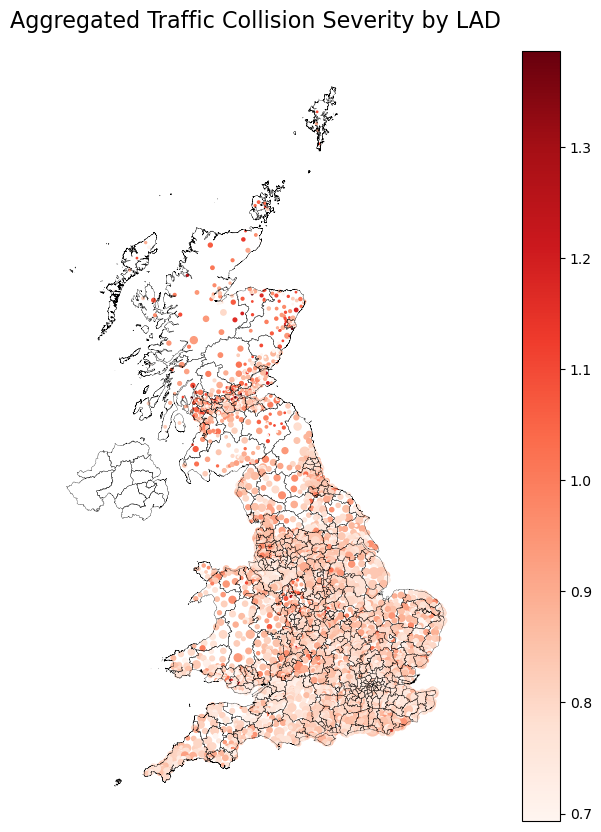

In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Assuming collision is your GeoDataFrame and temp_msoa is your MSOA shapefile

# Step 1: Calculate the weighted severity score for each MSOA
# Assign weights for severity levels: 1 (Fatal), 2 (Serious), 3 (Slight)
severity_weights = {1: np.log(4), 2: np.log(3), 3: np.log(2)}

# Create a weighted severity column
collision['weighted_severity'] = collision['accident_severity'].map(severity_weights)

# Aggregate data at the MSOA level
msoa_summary = collision.groupby('msoa_of_accident_location').agg(
    total_collisions=('accident_index', 'count'),
    severity_score=('weighted_severity', 'mean'),
    geometry=('geometry', 'first')  # Use the first point as the MSOA representative (could be centroid)
).reset_index()

# Step 2: Merge the MSOA summary data back with the MSOA geometries
msoa_summary = gpd.GeoDataFrame(msoa_summary, geometry='geometry', crs="EPSG:27700")

# If you want to use the centroid of MSOA polygons for the location of the points
msoa_summary['geometry'] = temp_msoa.set_index('geo_code').loc[msoa_summary['msoa_of_accident_location']].centroid.values

# Step 3: Plot the MSOA boundaries and the aggregated data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
temp_lad.boundary.plot(ax=ax, linewidth=0.2, color='black')

# Use the severity score to determine the color and total collisions for size
msoa_summary.plot(ax=ax, 
                  column='severity_score', 
                  cmap='Reds', 
                  markersize=msoa_summary['total_collisions'], 
                  legend=True,
                  alpha=1)

# Step 4: Customize the plot
ax.set_title('Aggregated Traffic Collision Severity by LAD', fontsize=16)
ax.set_axis_off()  # Hide the axis

# Save the figure if needed
plt.savefig('fig/aggregated_collision_severity.png', dpi=300)
plt.show()


In [14]:
collision.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 105871 entries, 0 to 106003
Data columns (total 27 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               105871 non-null  object        
 1   accident_severity                            105871 non-null  int64         
 2   number_of_vehicles                           105871 non-null  int64         
 3   number_of_casualties                         105871 non-null  int64         
 4   date                                         105871 non-null  datetime64[ns]
 5   day_of_week                                  105871 non-null  int64         
 6   time                                         105871 non-null  object        
 7   road_type                                    105871 non-null  int64         
 8   speed_limit                                  105871 non-null 

In [15]:
# Convert date and time to datetime objects
collision['date'] = pd.to_datetime(collision['date'])
collision['time_range'] = pd.to_datetime(collision['time'], format='%H:%M:%S').dt.time

# Extract features from datetime objects
collision['day_of_year'] = collision['date'].dt.dayofyear
collision['hour'] = collision['time'].apply(lambda x: x.hour)
collision['minute'] = collision['time'].apply(lambda x: x.minute)

# Drop original datetime columns if no longer needed
collision.drop(columns=['date', 'time', 'time_range'], inplace=True)

# Ensure hours and minutes are strings, and pad minutes with leading zeros if necessary
collision['time'] = collision['hour'].astype(str).str.zfill(2) + collision['minute'].astype(str).str.zfill(2)

collision.drop(columns=['hour', 'minute'], inplace=True)


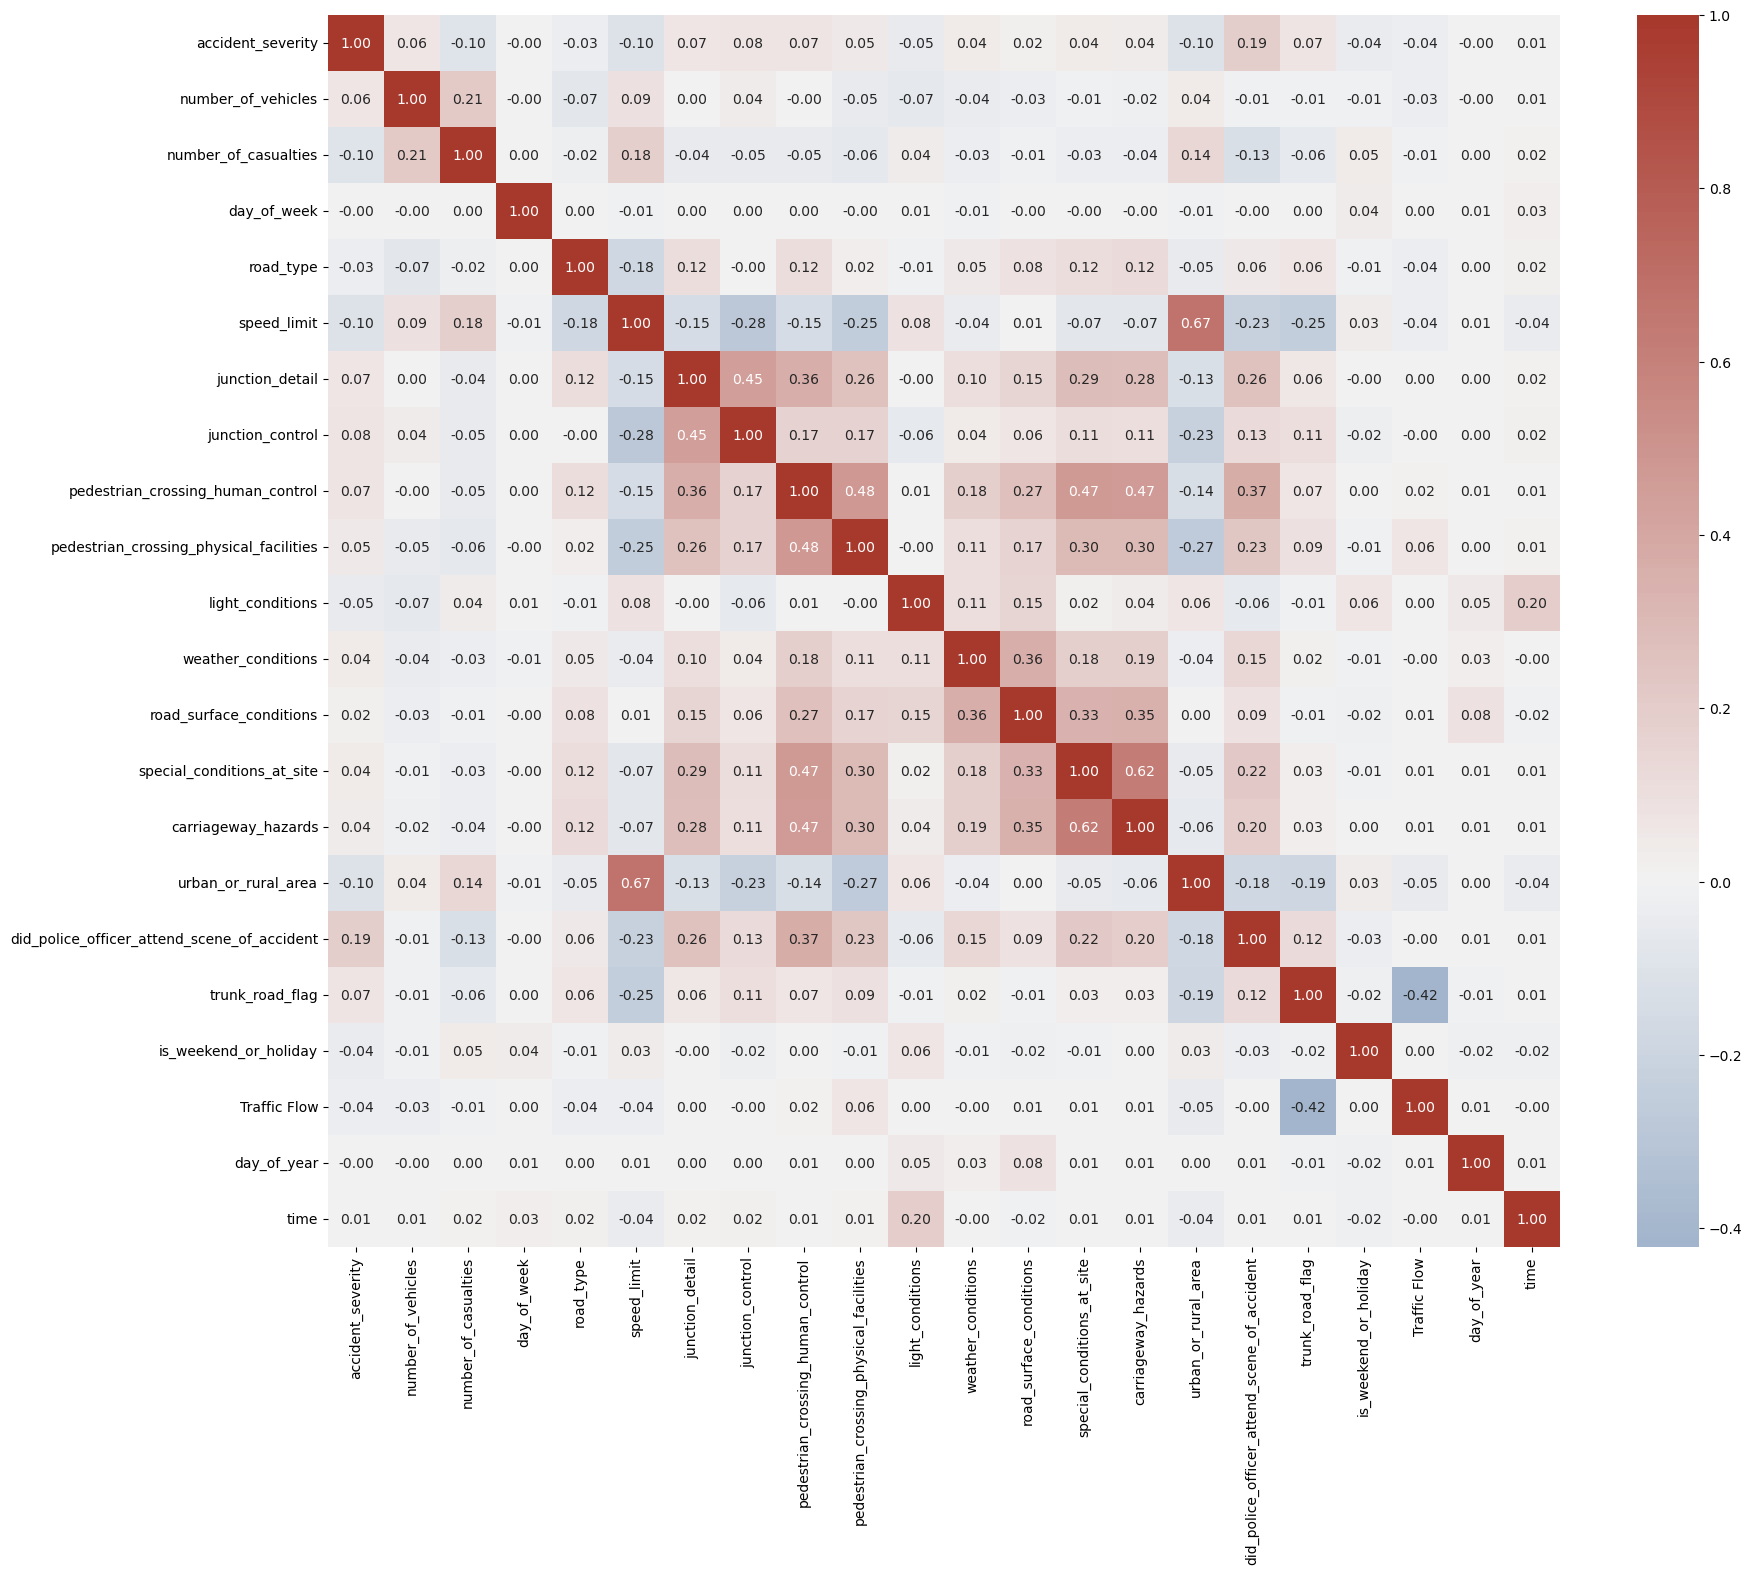

In [16]:
import seaborn  as sns

temp = collision.drop(['accident_index', 'msoa_of_accident_location', 'geometry', 'weighted_severity'], axis=1)
matrix = temp.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
 
plt.figure(figsize=(20, 16)) 
sns.heatmap(matrix,  center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.savefig('fig/correlation_matrix.png')
plt.show()

In [17]:
import geopandas as gpd

# Assuming 'collision' is your GeoDataFrame
working_days = collision[~collision['is_weekend_or_holiday']]
non_working_days = collision[collision['is_weekend_or_holiday']]


In [18]:
working_days = working_days.drop(['accident_index'], axis = 1)

In [19]:
working_days.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 76295 entries, 0 to 106003
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   accident_severity                            76295 non-null  int64   
 1   number_of_vehicles                           76295 non-null  int64   
 2   number_of_casualties                         76295 non-null  int64   
 3   day_of_week                                  76295 non-null  int64   
 4   road_type                                    76295 non-null  int64   
 5   speed_limit                                  76295 non-null  int64   
 6   junction_detail                              76295 non-null  int64   
 7   junction_control                             76295 non-null  int64   
 8   pedestrian_crossing_human_control            76295 non-null  int64   
 9   pedestrian_crossing_physical_facilities      76295 non-nu

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
working_days_geometry = working_days['geometry']
working_days = working_days.drop(['msoa_of_accident_location', 'geometry', 'msoa_of_accident_location'], axis = 1)


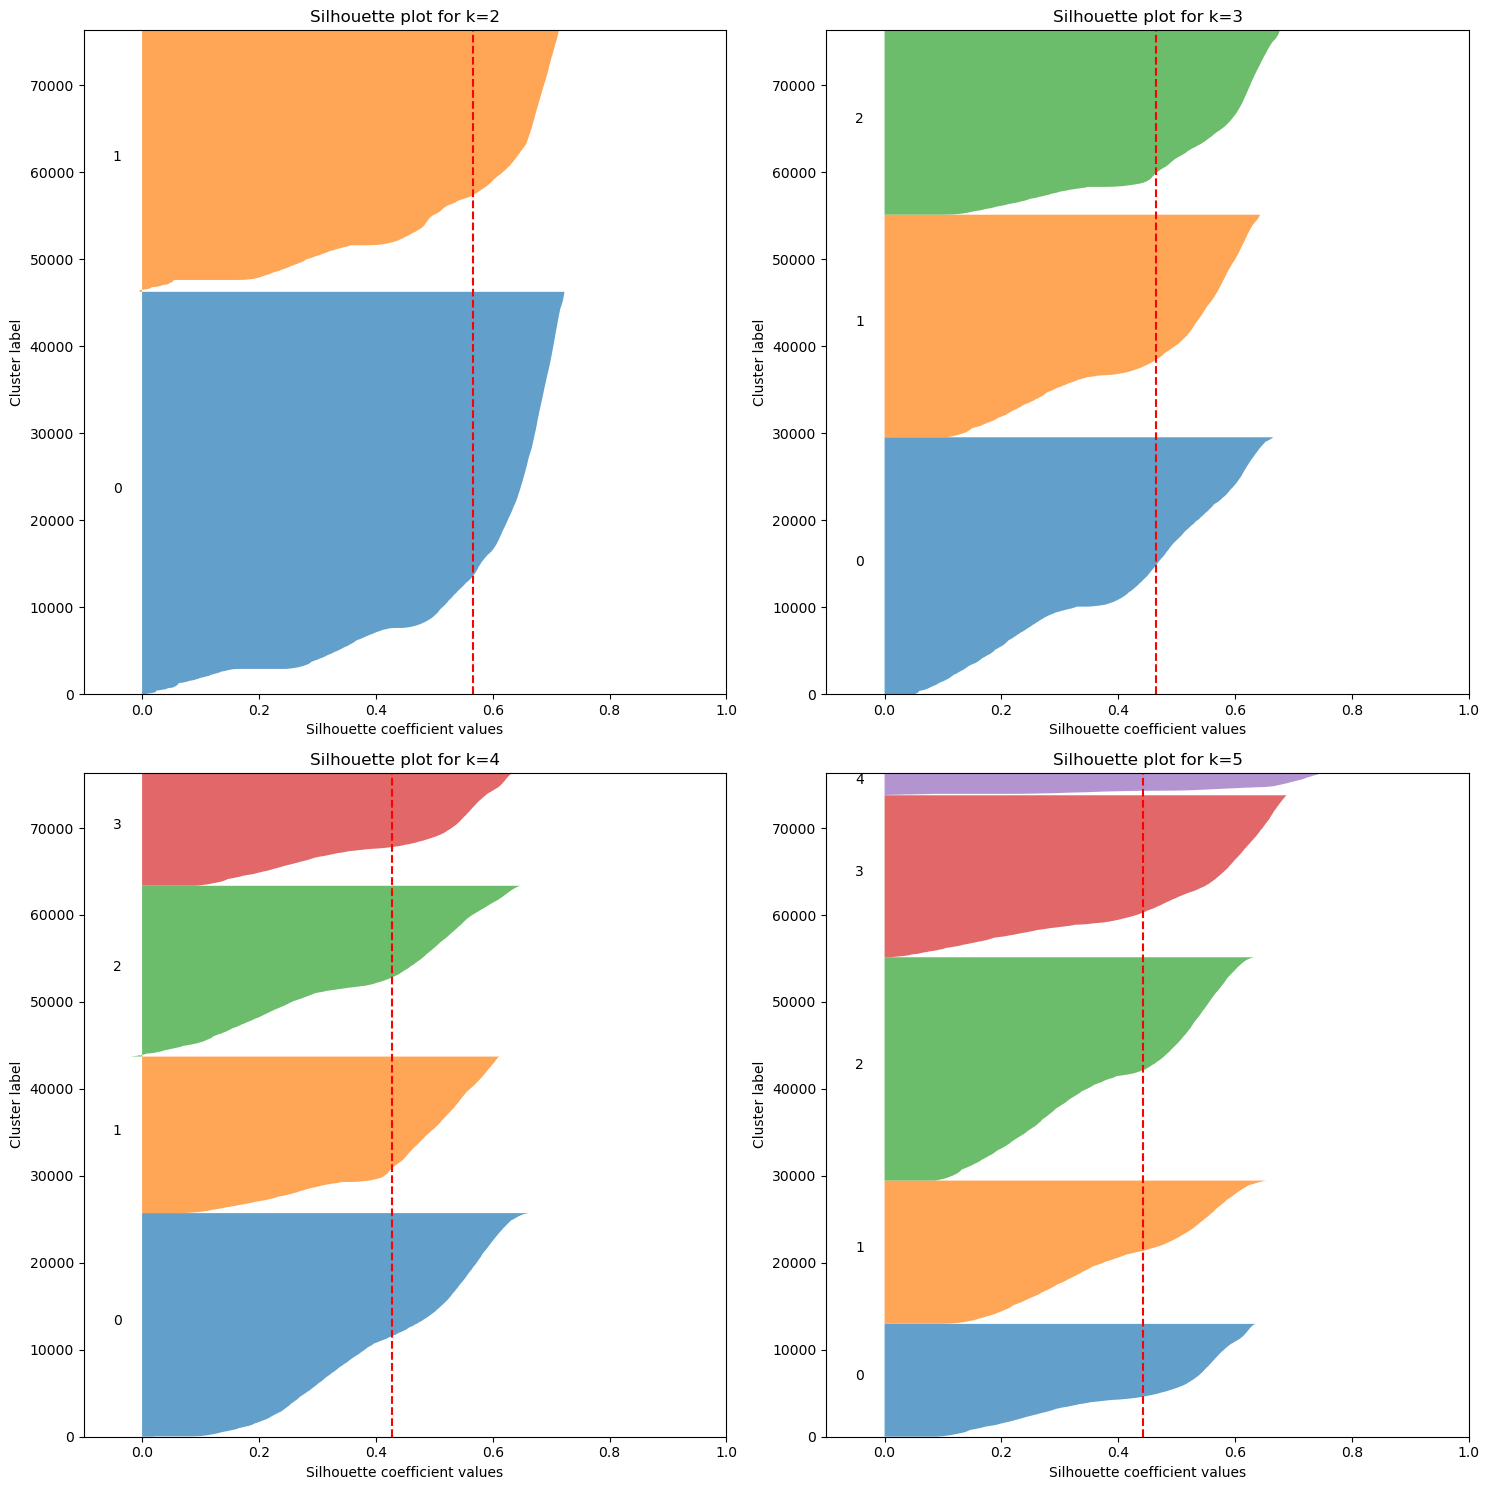

K-Means Silhouette Scores: {2: 0.5660839238955107, 3: 0.4636403851286704, 4: 0.42805145069172973, 5: 0.4416204746406574}
   Num_Clusters Cluster Num_Individuals  Percentage
0             2       0           46253   60.623894
1             2       1           30042   39.376106
2             3       0           29534   38.710269
3             3       1           25581   33.529065
4             3       2           21180   27.760666
5             4       0           25706   33.692903
6             4       1           17991   23.580838
7             4       2           19630   25.729078
8             4       3           12968   16.997182
9             5       0           12968   16.997182
10            5       1           16469   21.585949
11            5       2           25678   33.656203
12            5       3           18620   24.405269
13            5       4            2560    3.355397


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler


# Define the number of clusters to try
num_clusters = [2, 3, 4, 5]

# Initialize a dictionary to store silhouette scores
kmeans_scores = {}

# Set up subplots for silhouette plots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axs array for easier indexing
axs = axs.flatten()

# DataFrame to store cluster statistics
cluster_stats = pd.DataFrame(columns=['Num_Clusters', 'Cluster', 'Num_Individuals', 'Percentage'])

for idx, k in enumerate(num_clusters):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(working_days)

    # Calculate the silhouette score
    score = silhouette_score(working_days, labels)
    kmeans_scores[k] = score
    
    # Calculate silhouette samples
    silhouette_vals = silhouette_samples(working_days, labels)

    # Silhouette plot
    axs[idx].set_xlim([-0.1, 1])
    axs[idx].set_ylim([0, len(working_days) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_vals = silhouette_vals[labels == i]
        ith_cluster_silhouette_vals.sort()

        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        axs[idx].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
        axs[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    axs[idx].set_title(f'Silhouette plot for k={k}')
    axs[idx].set_xlabel("Silhouette coefficient values")
    axs[idx].set_ylabel("Cluster label")

    axs[idx].axvline(x=score, color="red", linestyle="--")

    # Calculate and store the number of individuals in each cluster and their percentages
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    percentages = (cluster_sizes / len(working_days)) * 100

    temp_df = pd.DataFrame({
        'Num_Clusters': k,
        'Cluster': cluster_sizes.index,
        'Num_Individuals': cluster_sizes.values,
        'Percentage': percentages.values
    })

    cluster_stats = pd.concat([cluster_stats, temp_df], ignore_index=True)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('fig/silhouette_2x2.png')
plt.show()

# Print silhouette scores for reference
print("K-Means Silhouette Scores:", kmeans_scores)

# Display the cluster statistics table
print(cluster_stats)


In [22]:
working_days = working_days.drop(['is_weekend_or_holiday'], axis = 1)


# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
working_days_scaled = pd.DataFrame(scaler.fit_transform(working_days), columns=working_days.columns, index=working_days.index)

working_days_scaled

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,road_type,speed_limit,junction_detail,junction_control,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,...,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,Traffic Flow,weighted_severity,day_of_year,time
0,1.0,0.083333,0.000000,0.50,0.625,0.2,0.060606,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.104941,0.000000,0.002778,0.695210
83,0.5,0.000000,0.000000,0.25,0.625,0.2,0.030303,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.068758,0.584963,0.000000,0.048326
84,1.0,0.083333,0.000000,0.25,0.125,0.0,0.030303,0.3,0.1,0.6,...,0.2,0.1,0.1,0.0,0.0,1.0,0.128536,0.000000,0.000000,0.219161
85,0.5,0.083333,0.000000,0.25,0.250,0.0,0.060606,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.055140,0.584963,0.000000,0.311997
86,1.0,0.083333,0.000000,0.25,0.250,0.4,0.060606,0.3,0.1,0.6,...,0.2,0.1,0.1,0.0,0.0,1.0,0.089816,0.000000,0.000000,0.267062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105997,0.5,0.000000,0.066667,0.25,0.625,0.2,0.060606,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,0.0,0.560346,0.584963,0.777778,0.059347
105998,1.0,0.083333,0.000000,0.25,0.625,0.2,0.030303,0.5,0.1,0.1,...,0.2,0.1,0.3,0.0,0.5,0.0,0.560346,0.000000,0.583333,0.635863
106001,1.0,0.000000,0.000000,1.00,0.625,0.2,0.060606,0.3,0.1,0.6,...,0.2,0.1,0.1,0.0,0.5,0.0,0.560346,0.000000,0.494444,0.484951
106002,0.5,0.000000,0.000000,1.00,0.625,0.2,0.030303,0.5,0.1,0.9,...,0.2,0.1,0.1,0.0,0.0,0.0,0.560346,0.584963,0.922222,0.697329


In [24]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(working_days)
working_days_scaled['cluster'] = labels
working_days_scaled['geometry'] = working_days_geometry

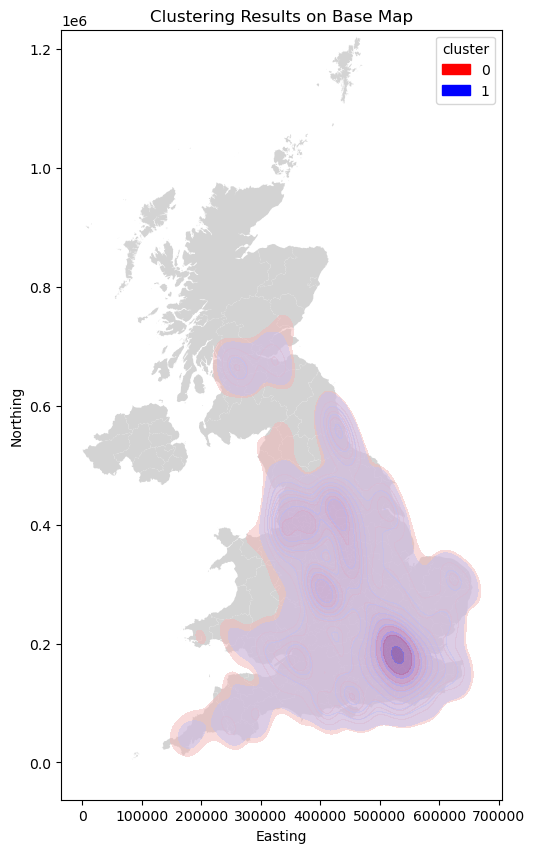

In [25]:
import seaborn as sns
from matplotlib.colors import ListedColormap
gdf_work = gpd.GeoDataFrame(working_days_scaled, geometry='geometry')

# Extract x and y coordinates
gdf_work['x'] = gdf_work.geometry.x
gdf_work['y'] = gdf_work.geometry.y

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
temp_lad.plot(ax=ax, color='lightgrey')

# KDE plot
sns.kdeplot(x=gdf_work['x'], y=gdf_work['y'], hue=gdf_work['cluster'], fill=True, palette=['red', 'blue'], alpha=0.5, ax=ax)

# Titles and labels
plt.title('Clustering Results on Base Map')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.savefig('fig/clustering.png')
plt.show()


In [26]:
working_days_scaled = working_days_scaled.drop(['geometry'], axis = 1)

In [27]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming your dataframe is called 'working_days'

# List of variables to analyze
variables = list(working_days_scaled)

# Create a results dictionary
results = {}

for var in variables:
    # Calculate mean and std for each cluster
    cluster_stats = working_days_scaled.groupby('cluster')[var].agg(['mean', 'std'])
    
    # Perform one-way ANOVA
    cluster_0 = working_days_scaled[working_days_scaled['cluster'] == 0][var]
    cluster_1 = working_days_scaled[working_days_scaled['cluster'] == 1][var]
    f_value, p_value = stats.f_oneway(cluster_0, cluster_1)
    
    results[var] = {
        'Cluster 1 Mean': cluster_stats.loc[0, 'mean'],
        'Cluster 1 SD': cluster_stats.loc[0, 'std'],
        'Cluster 2 Mean': cluster_stats.loc[1, 'mean'],
        'Cluster 2 SD': cluster_stats.loc[1, 'std'],
        'F': f_value,
        'P-value': p_value
    }

# Create a DataFrame from the results
results_df = pd.DataFrame(results).T

# Format the DataFrame
results_df = results_df.round(3)
results_df['P-value'] = results_df['P-value'].apply(lambda x: f"{x:.3f}" if x >= 0.001 else "<0.001")

# Display the results
print(results_df.to_string())

                                             Cluster 1 Mean  Cluster 1 SD  Cluster 2 Mean  Cluster 2 SD           F P-value
accident_severity                                     0.880         0.228           0.882         0.229       2.498   0.114
number_of_vehicles                                    0.069         0.056           0.070         0.057       4.611   0.032
number_of_casualties                                  0.018         0.045           0.016         0.042      34.136  <0.001
day_of_week                                           0.538         0.352           0.522         0.350      40.342  <0.001
road_type                                             0.536         0.210           0.528         0.216      30.108  <0.001
speed_limit                                           0.305         0.275           0.326         0.289     103.286  <0.001
junction_detail                                       0.042         0.132           0.039         0.123       9.040   0.003
junction

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer

# Assuming 'working_days_scaled' is your scaled DataFrame and 'cluster' is the column indicating the cluster
cluster_0_data = working_days_scaled[working_days_scaled['cluster'] == 0]
cluster_1_data = working_days_scaled[working_days_scaled['cluster'] == 1]

# Drop the cluster column before factor analysis
cluster_0_data = cluster_0_data.drop(columns=['cluster'])
cluster_1_data = cluster_1_data.drop(columns=['cluster'])

from factor_analyzer import FactorAnalyzer

# Function to perform factor analysis and varimax rotation
def perform_factor_analysis(data, n_factors):
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(data)
    loadings = pd.DataFrame(fa.loadings_, index=data.columns)
    return loadings

# Choose the number of factors based on previous analysis (e.g., 5)
n_factors = 5

# Perform factor analysis for Cluster 0
cluster_0_loadings = perform_factor_analysis(cluster_0_data, n_factors)
print("Cluster 0 Factor Loadings:")
print(cluster_0_loadings)

# Perform factor analysis for Cluster 1
cluster_1_loadings = perform_factor_analysis(cluster_1_data, n_factors)
print("\nCluster 1 Factor Loadings:")
print(cluster_1_loadings)


Cluster 0 Factor Loadings:
                                                    0         1         2  \
accident_severity                            0.050000  0.992592 -0.060042   
number_of_vehicles                          -0.009126  0.075986  0.138748   
number_of_casualties                        -0.044098 -0.061824  0.223620   
day_of_week                                 -0.006526 -0.009808  0.009881   
road_type                                    0.154575 -0.055854 -0.102734   
speed_limit                                 -0.076447 -0.030072  0.856987   
junction_detail                              0.459593  0.032415 -0.190267   
junction_control                             0.223158  0.042955 -0.286386   
pedestrian_crossing_human_control            0.703155  0.035440 -0.142763   
pedestrian_crossing_physical_facilities      0.451249  0.013790 -0.276374   
light_conditions                             0.048163  0.018407  0.040830   
weather_conditions                           0.32

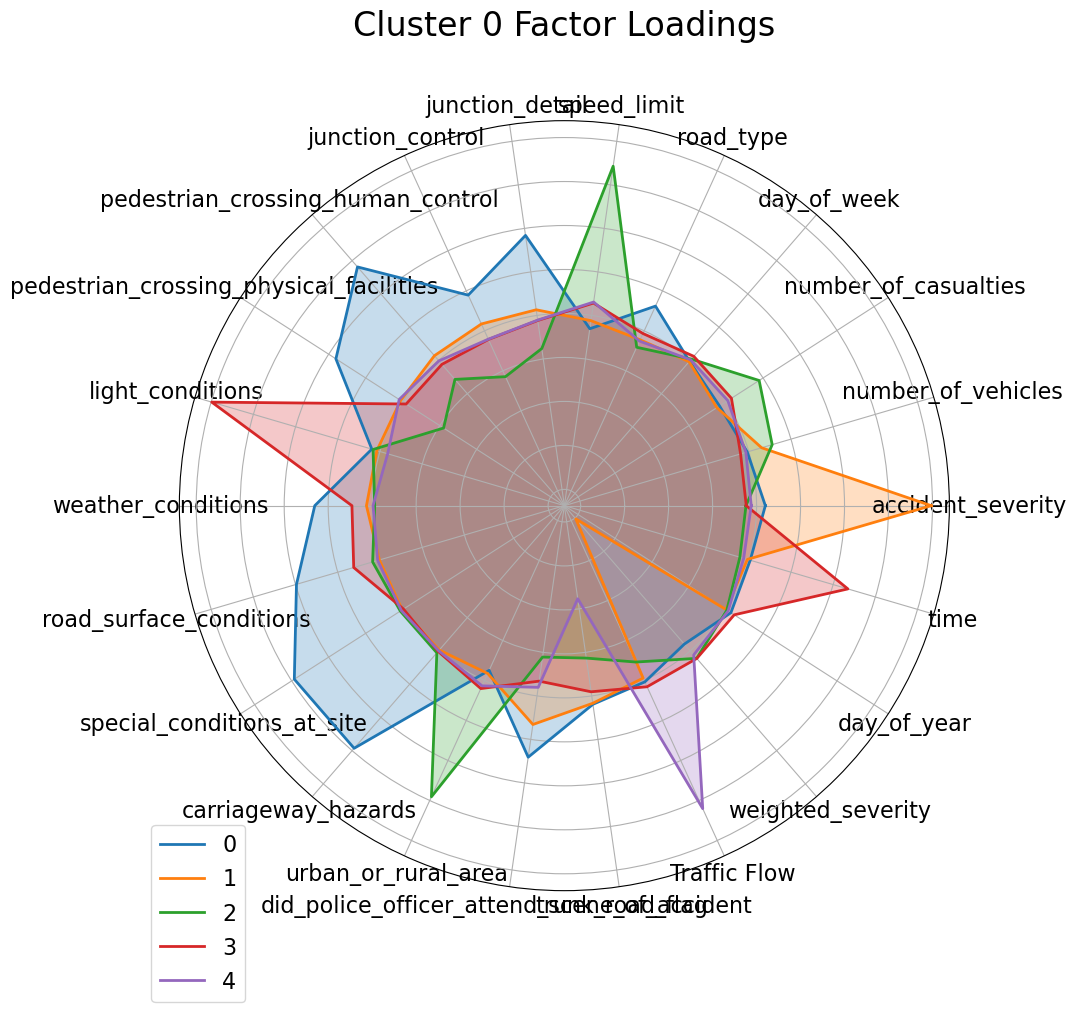

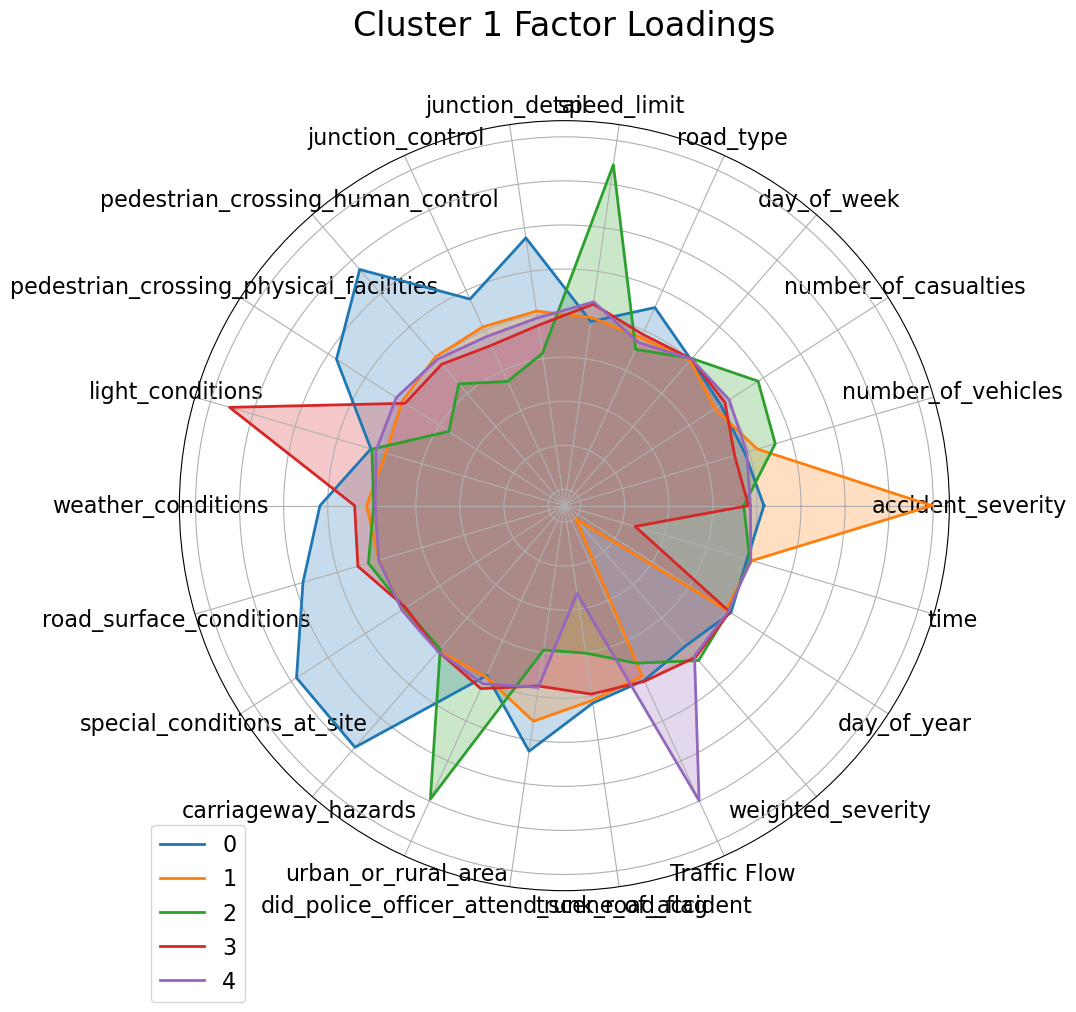

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar_chart(data, title, font_size=14, title_font_size=20, legend_font_size=14):
    # Number of variables
    categories = list(data.index)
    N = len(categories)
    
    # Compute angle of each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # To complete the circle

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one line per factor
    for col in data.columns:
        values = data[col].tolist()
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=col)
        ax.fill(angles, values, alpha=0.25)

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=font_size)  # Set font size for the factors
    ax.set_yticklabels([])  # Optionally set font size for radial ticks

    # Title and legend
    plt.title(title, size=title_font_size, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=legend_font_size)

    plt.show()

plot_radar_chart(cluster_0_loadings, "Cluster 0 Factor Loadings", font_size=16, title_font_size=24, legend_font_size=16)
plot_radar_chart(cluster_1_loadings, "Cluster 1 Factor Loadings", font_size=16, title_font_size=24, legend_font_size=16)


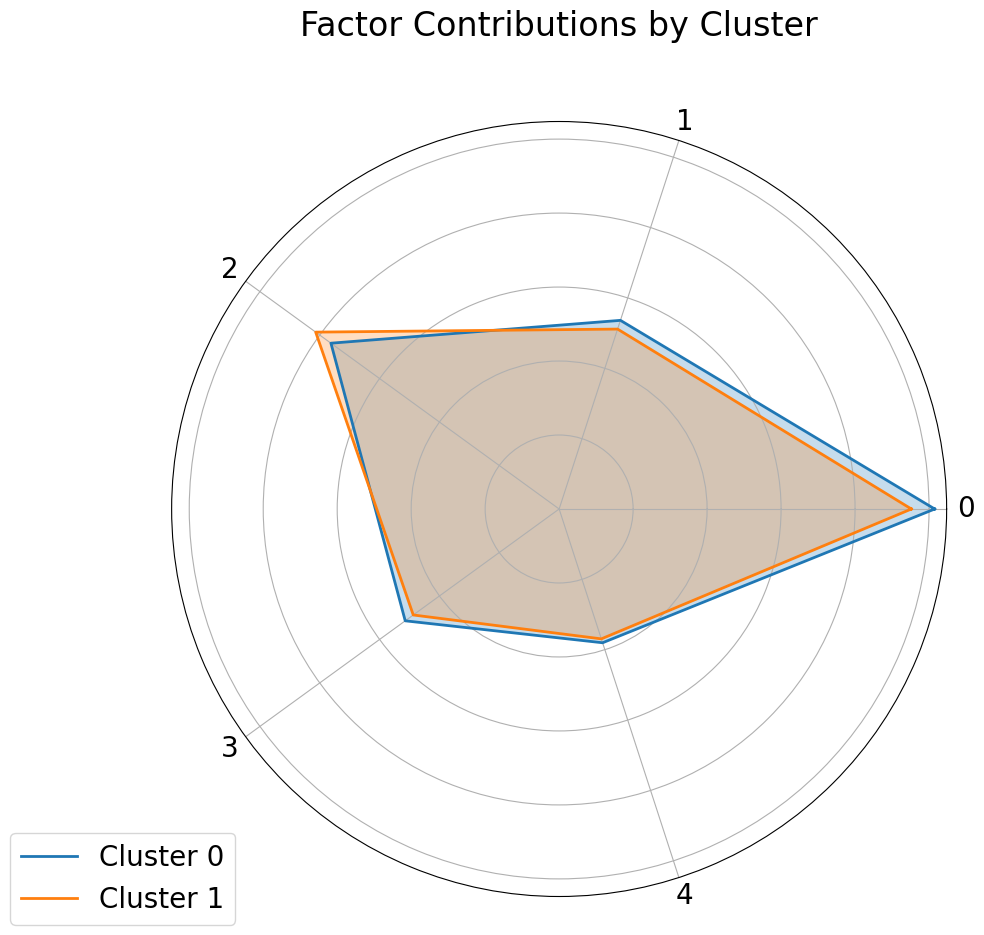

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate contributions as the sum of the absolute values of the loadings
cluster_0_contributions = cluster_0_loadings.abs().sum(axis=0)
cluster_1_contributions = cluster_1_loadings.abs().sum(axis=0)

# Combine into a DataFrame
contributions_df = pd.DataFrame({
    'Cluster 0': cluster_0_contributions,
    'Cluster 1': cluster_1_contributions
}).T

# Function to plot radar chart
def plot_radar_chart(data, title, font_size=14, title_font_size=20, legend_font_size=14):
    # Number of variables
    categories = list(data.columns)
    N = len(categories)
    
    # Compute angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 12), subplot_kw=dict(polar=True))
    
    # Plot each cluster
    for i, row in data.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the circle.
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=i)
        ax.fill(angles, values, alpha=0.25)

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=font_size)  # Set font size for the factors
    ax.set_yticklabels([])

    # Title and legend
    plt.title(title, size=title_font_size, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=legend_font_size)
    
    # Save and show the plot
    plt.savefig('fig/radar_chart.png')
    plt.show()

# Plot the radar chart
plot_radar_chart(contributions_df, "Factor Contributions by Cluster", font_size=20, title_font_size=24, legend_font_size=20)


In [31]:
non_working_days = non_working_days.drop(['accident_index'], axis = 1)
non_working_days_geometry = non_working_days['geometry']
non_working_days = non_working_days.drop(['msoa_of_accident_location', 'geometry', 'msoa_of_accident_location'], axis = 1)


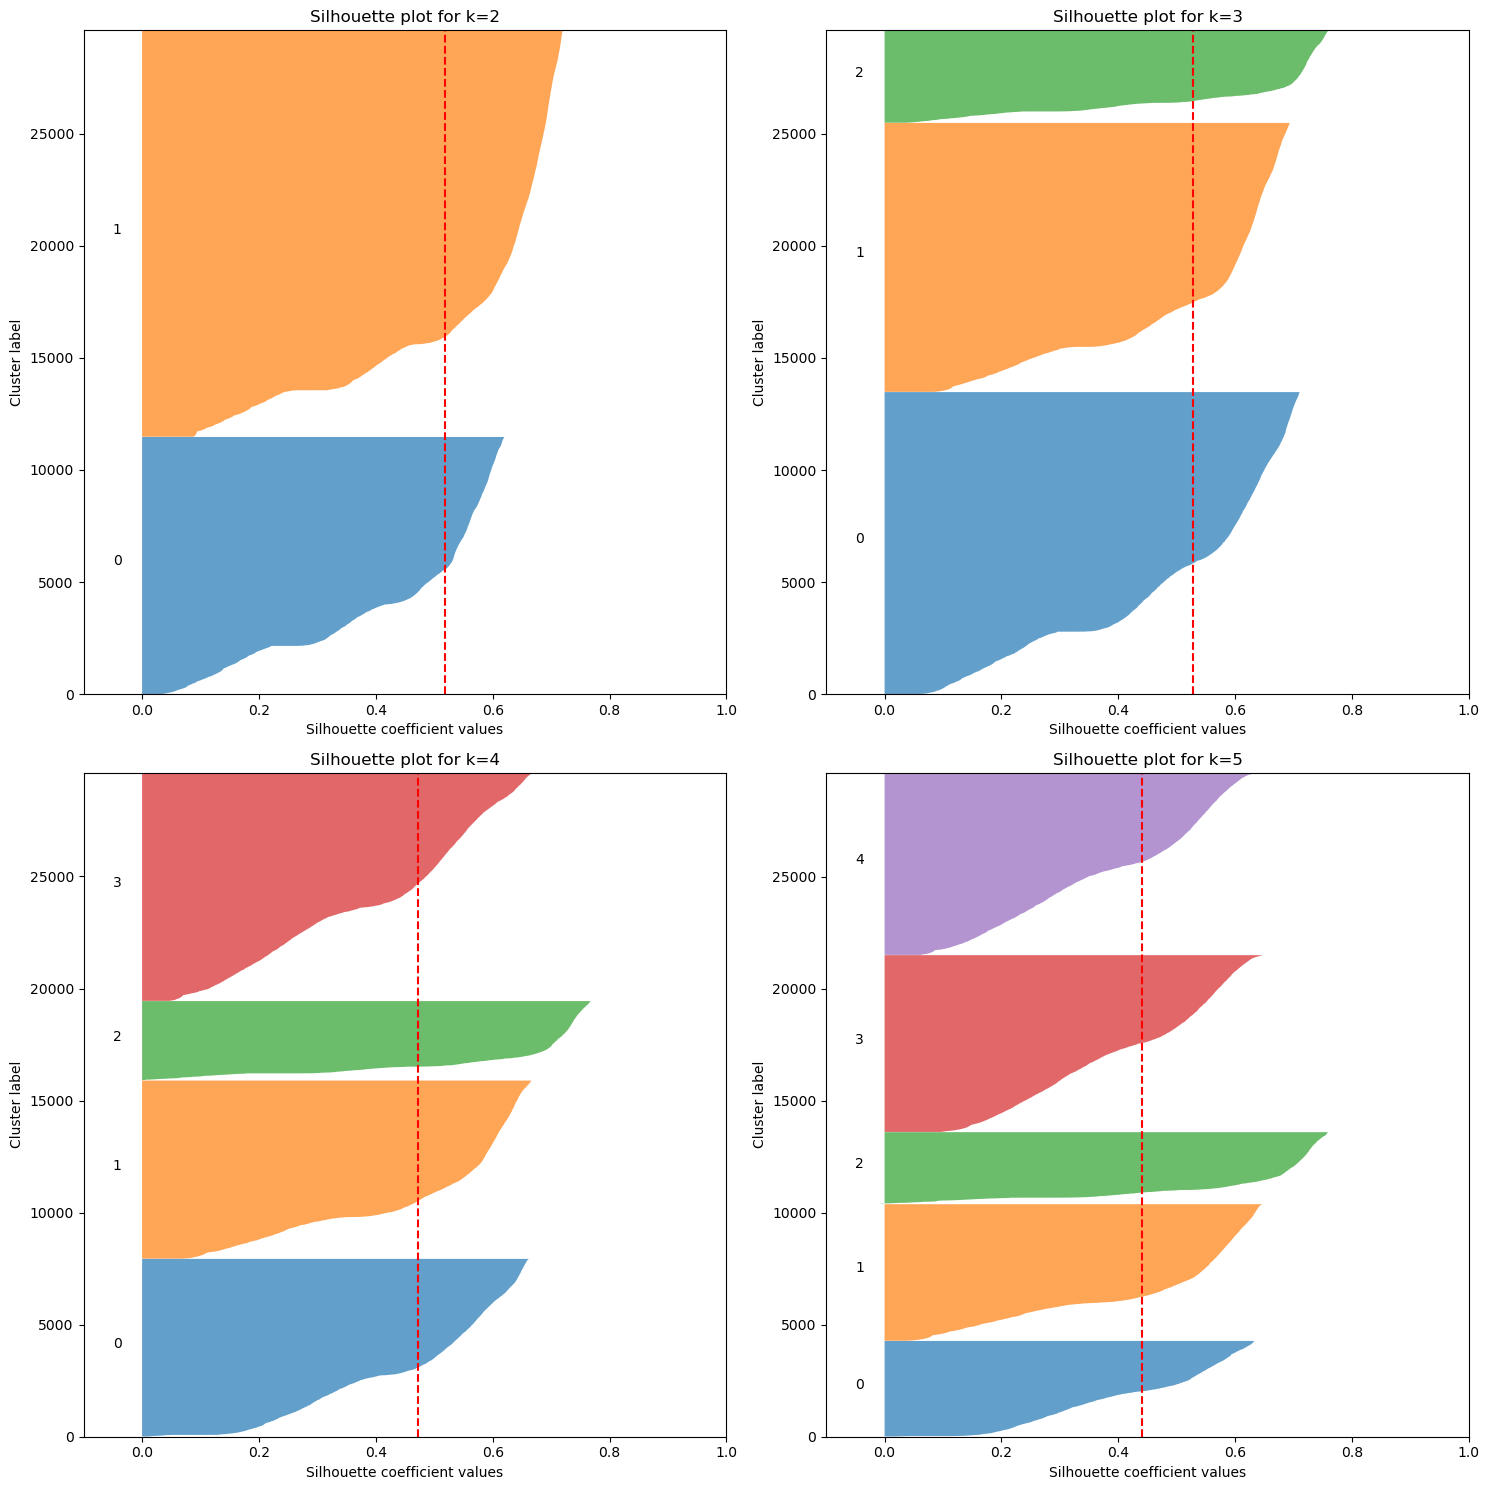

K-Means Silhouette Scores: {2: 0.5187262053605959, 3: 0.5284349904623231, 4: 0.47145008370285707, 5: 0.44048272085781626}
   Num_Clusters Cluster Num_Individuals  Percentage
0             2       0           11463   38.757777
1             2       1           18113   61.242223
2             3       0           13469   45.540303
3             3       1           11997   40.563295
4             3       2            4110   13.896402
5             4       0            7927   26.802137
6             4       1            7948   26.873140
7             4       2            3536   11.955640
8             4       3           10165   34.369083
9             5       0            4266   14.423857
10            5       1            6094   20.604544
11            5       2            3206   10.839870
12            5       3            7892   26.683798
13            5       4            8118   27.447931


In [32]:
# Define the number of clusters to try
num_clusters = [2, 3, 4, 5]

# Initialize a dictionary to store silhouette scores
kmeans_scores = {}

# Set up subplots for silhouette plots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axs array for easier indexing
axs = axs.flatten()

# DataFrame to store cluster statistics
cluster_stats = pd.DataFrame(columns=['Num_Clusters', 'Cluster', 'Num_Individuals', 'Percentage'])

for idx, k in enumerate(num_clusters):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(non_working_days)

    # Calculate the silhouette score
    score = silhouette_score(non_working_days, labels)
    kmeans_scores[k] = score
    
    # Calculate silhouette samples
    silhouette_vals = silhouette_samples(non_working_days, labels)

    # Silhouette plot
    axs[idx].set_xlim([-0.1, 1])
    axs[idx].set_ylim([0, len(non_working_days) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_vals = silhouette_vals[labels == i]
        ith_cluster_silhouette_vals.sort()

        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        axs[idx].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
        axs[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    axs[idx].set_title(f'Silhouette plot for k={k}')
    axs[idx].set_xlabel("Silhouette coefficient values")
    axs[idx].set_ylabel("Cluster label")

    axs[idx].axvline(x=score, color="red", linestyle="--")

    # Calculate and store the number of individuals in each cluster and their percentages
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    percentages = (cluster_sizes / len(non_working_days)) * 100

    temp_df = pd.DataFrame({
        'Num_Clusters': k,
        'Cluster': cluster_sizes.index,
        'Num_Individuals': cluster_sizes.values,
        'Percentage': percentages.values
    })

    cluster_stats = pd.concat([cluster_stats, temp_df], ignore_index=True)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('fig/silhouette_2x2_no.png')
plt.show()

# Print silhouette scores for reference
print("K-Means Silhouette Scores:", kmeans_scores)

# Display the cluster statistics table
print(cluster_stats)


In [33]:
non_working_days = non_working_days.drop(['is_weekend_or_holiday'], axis = 1)


# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
non_working_days_scaled = pd.DataFrame(scaler.fit_transform(non_working_days), columns=non_working_days.columns, index=non_working_days.index)

non_working_days_scaled

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,road_type,speed_limit,junction_detail,junction_control,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,...,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,Traffic Flow,weighted_severity,day_of_year,time
1,1.0,0.066667,0.000000,1.0,0.250,0.6,0.060606,0.3,0.1,0.5,...,0.2,0.1,0.1,1.0,0.0,1.0,0.145615,0.000000,0.000000,0.049597
2,1.0,0.066667,0.000000,1.0,0.625,0.2,0.090909,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.122723,0.000000,0.000000,0.048749
3,1.0,0.066667,0.076923,1.0,0.625,0.2,0.000000,0.0,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.054959,0.000000,0.000000,0.094955
4,1.0,0.200000,0.153846,1.0,0.250,0.6,0.050505,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.123375,0.000000,0.000000,0.097499
5,0.5,0.000000,0.307692,1.0,0.625,0.2,0.030303,0.5,0.1,0.1,...,0.2,0.1,0.1,0.0,0.0,1.0,0.034752,0.584963,0.000000,0.108097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105988,1.0,0.333333,0.000000,1.0,0.250,1.0,0.000000,0.0,0.1,0.1,...,0.5,0.1,0.4,1.0,0.0,0.0,0.549741,0.000000,0.961538,0.400170
105989,1.0,0.000000,0.000000,1.0,0.625,0.2,0.090909,0.5,0.1,0.1,...,0.3,0.1,0.1,0.0,0.5,0.0,0.549741,0.000000,0.826923,0.575244
105993,0.5,0.000000,0.076923,0.0,0.250,1.0,0.010101,0.5,0.1,0.1,...,0.3,0.1,0.1,1.0,1.0,0.0,0.549741,0.584963,0.983516,0.192878
105999,0.5,0.000000,0.000000,1.0,0.625,0.2,0.060606,0.3,0.1,0.2,...,0.2,0.1,0.1,0.0,0.5,0.0,0.549741,0.584963,0.980769,0.635863


In [34]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(non_working_days)
non_working_days_scaled['cluster'] = labels
non_working_days_scaled['geometry'] = non_working_days_geometry

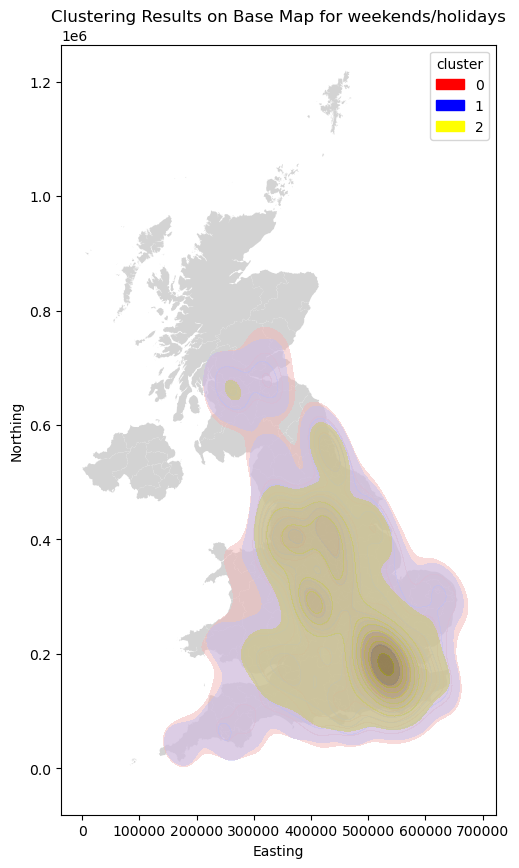

In [35]:
import seaborn as sns

gdf_non_work = gpd.GeoDataFrame(non_working_days_scaled, geometry='geometry')

# Extract x and y coordinates
gdf_non_work['x'] = gdf_non_work.geometry.x
gdf_non_work['y'] = gdf_non_work.geometry.y

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
temp_lad.plot(ax=ax, color='lightgrey')

# KDE plot
sns.kdeplot(x=gdf_non_work['x'], y=gdf_non_work['y'], hue=gdf_non_work['cluster'], fill=True, palette=['red', 'blue', 'yellow'], alpha=0.5, ax=ax)

# Titles and labels
plt.title('Clustering Results on Base Map for weekends/holidays')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.savefig('fig/clustering_no.png')
plt.show()


In [36]:
non_working_days_scaled = non_working_days_scaled.drop(['geometry'], axis =1)

In [37]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming your dataframe is called 'non_working_days_scaled'

# List of variables to analyze
variables = list(non_working_days_scaled.columns.difference(['cluster']))

# Create a results dictionary
results = {}

for var in variables:
    # Ensure no NaN values in the variable
    if non_working_days_scaled[var].isna().any():
        print(f"Warning: Missing values found in variable {var}")
        continue
    
    # Check cluster sizes
    cluster_sizes = non_working_days_scaled.groupby('cluster')[var].size()
    if any(cluster_sizes == 0):
        print(f"Warning: One or more clusters have no data for variable {var}")
        continue
    
    # Calculate mean and std for each cluster
    cluster_stats = non_working_days_scaled.groupby('cluster')[var].agg(['mean', 'std'])
    
    # Perform one-way ANOVA
    try:
        cluster_0 = non_working_days_scaled[non_working_days_scaled['cluster'] == 0][var]
        cluster_1 = non_working_days_scaled[non_working_days_scaled['cluster'] == 1][var]
        cluster_2 = non_working_days_scaled[non_working_days_scaled['cluster'] == 2][var]
        
        # Check if any cluster has only one value
        if len(cluster_0) < 2 or len(cluster_1) < 2 or len(cluster_2) < 2:
            print(f"Warning: Not enough data points for variable {var}")
            continue
        
        f_value, p_value = stats.f_oneway(cluster_0, cluster_1, cluster_2)
        
        results[var] = {
            'Cluster 0 Mean': cluster_stats.loc[0, 'mean'],
            'Cluster 0 SD': cluster_stats.loc[0, 'std'],
            'Cluster 1 Mean': cluster_stats.loc[1, 'mean'],
            'Cluster 1 SD': cluster_stats.loc[1, 'std'],
            'Cluster 2 Mean': cluster_stats.loc[2, 'mean'],
            'Cluster 2 SD': cluster_stats.loc[2, 'std'],
            'F': f_value,
            'P-value': p_value
        }
    except Exception as e:
        print(f"Error processing variable {var}: {e}")

# Create a DataFrame from the results
results_df = pd.DataFrame(results).T

# Format the DataFrame
results_df = results_df.round(3)
results_df['P-value'] = results_df['P-value'].apply(lambda x: f"{x:.3f}" if x >= 0.001 else "<0.001")

# Display the results
print(results_df.to_string())


                                             Cluster 0 Mean  Cluster 0 SD  Cluster 1 Mean  Cluster 1 SD  Cluster 2 Mean  Cluster 2 SD          F P-value
Traffic Flow                                          0.108         0.133           0.111         0.137           0.115         0.140      5.601   0.004
accident_severity                                     0.864         0.239           0.865         0.242           0.828         0.275     38.507  <0.001
carriageway_hazards                                   0.117         0.114           0.122         0.130           0.126         0.138     12.068  <0.001
day_of_week                                           0.551         0.482           0.560         0.480           0.496         0.487     27.463  <0.001
day_of_year                                           0.490         0.277           0.502         0.284           0.498         0.287      5.474   0.004
did_police_officer_attend_scene_of_accident           0.235         0.382         

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer

# Assuming 'working_days_scaled' is your scaled DataFrame and 'cluster' is the column indicating the cluster
cluster_0_data = non_working_days_scaled[non_working_days_scaled['cluster'] == 0]
cluster_1_data = non_working_days_scaled[non_working_days_scaled['cluster'] == 1]
cluster_2_data = non_working_days_scaled[non_working_days_scaled['cluster'] == 2]

# Drop the cluster column before factor analysis
cluster_0_data = cluster_0_data.drop(columns=['cluster'])
cluster_1_data = cluster_1_data.drop(columns=['cluster'])
cluster_2_data = cluster_2_data.drop(columns=['cluster'])

from factor_analyzer import FactorAnalyzer

# Function to perform factor analysis and varimax rotation
def perform_factor_analysis(data, n_factors):
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(data)
    loadings = pd.DataFrame(fa.loadings_, index=data.columns)
    return loadings

# Choose the number of factors based on previous analysis (e.g., 5)
n_factors = 5

# Perform factor analysis for Cluster 0
cluster_0_loadings = perform_factor_analysis(cluster_0_data, n_factors)
print("Cluster 0 Factor Loadings:")
print(cluster_0_loadings)

# Perform factor analysis for Cluster 1
cluster_1_loadings = perform_factor_analysis(cluster_1_data, n_factors)
print("\nCluster 1 Factor Loadings:")
print(cluster_1_loadings)

# Perform factor analysis for Cluster 1
cluster_2_loadings = perform_factor_analysis(cluster_2_data, n_factors)
print("\nCluster 2 Factor Loadings:")
print(cluster_2_loadings)


Cluster 0 Factor Loadings:
                                                    0         1         2  \
accident_severity                            0.992340  0.030769 -0.058697   
number_of_vehicles                           0.061890 -0.049874  0.172780   
number_of_casualties                        -0.065865 -0.048701  0.240100   
day_of_week                                  0.021271 -0.001770 -0.031293   
road_type                                   -0.070033  0.133522 -0.091905   
speed_limit                                 -0.070291 -0.034022  0.844829   
junction_detail                              0.012571  0.197142  0.022847   
junction_control                             0.046145  0.010352 -0.134192   
pedestrian_crossing_human_control            0.032653  0.604858 -0.103433   
pedestrian_crossing_physical_facilities      0.029431  0.396441 -0.251373   
light_conditions                            -0.002693  0.078366  0.007704   
weather_conditions                           0.03

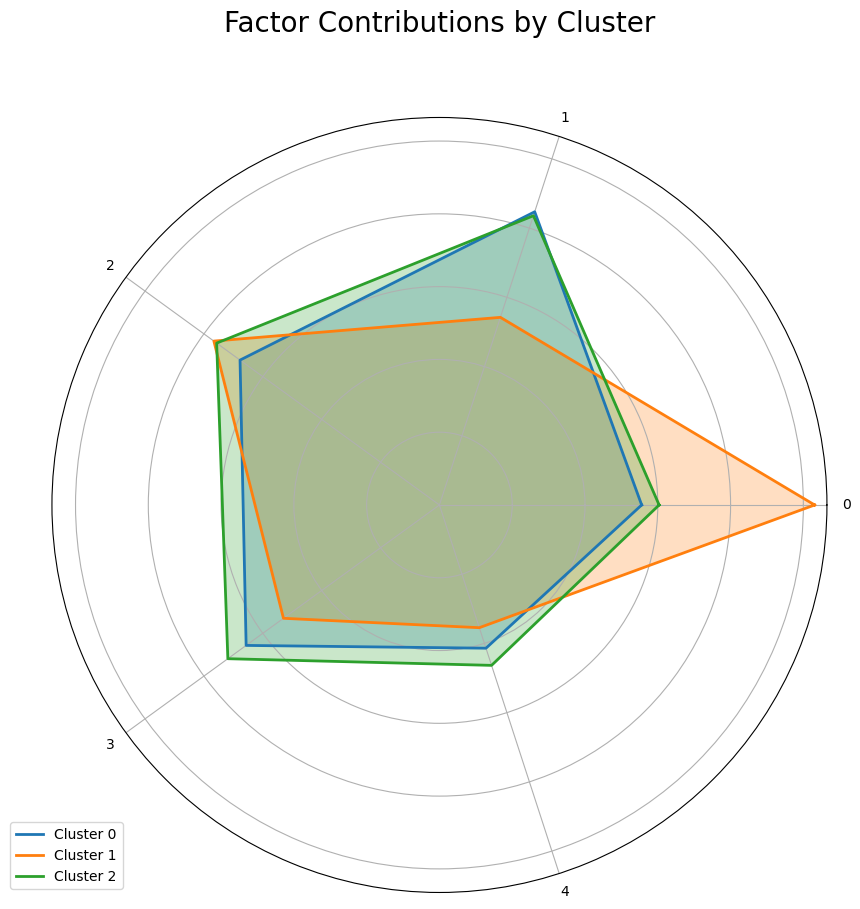

In [39]:
# Calculate contributions as the sum of the absolute values of the loadings
cluster_0_contributions = cluster_0_loadings.abs().sum(axis=0)
cluster_1_contributions = cluster_1_loadings.abs().sum(axis=0)
cluster_2_contributions = cluster_2_loadings.abs().sum(axis=0)

# Combine into a DataFrame
contributions_df = pd.DataFrame({
    'Cluster 0': cluster_0_contributions,
    'Cluster 1': cluster_1_contributions,
    'Cluster 2': cluster_2_contributions
}).T

# Function to plot radar chart
def plot_radar_chart(data, title, font_size=14, title_font_size=20, legend_font_size=14):
    # Number of variables
    categories = list(data.columns)
    N = len(categories)
    
    # Compute angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 12), subplot_kw=dict(polar=True))
    
    # Plot each cluster
    for i, row in data.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=i)
        ax.fill(angles, values, alpha=0.25)

    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([])

    # Title and legend
    plt.title(title, size=20, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.savefig('fig/radar_char_no.png')
    plt.show()

# Plot the radar chart
plot_radar_chart(contributions_df, "Factor Contributions by Cluster", font_size=20, title_font_size=24, legend_font_size=20)